In [539]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

print(tf.__version__)

2.3.0


In [540]:
penguins_raw = pd.read_csv('/kaggle/input/palmer-archipelago-antarctica-penguin-data/penguins_size.csv', na_values='NA', skipinitialspace=True)
print(penguins_raw.tail())
print("Columns: ", penguins_raw.columns)

    species  island  culmen_length_mm  culmen_depth_mm  flipper_length_mm  \
339  Gentoo  Biscoe               NaN              NaN                NaN   
340  Gentoo  Biscoe              46.8             14.3              215.0   
341  Gentoo  Biscoe              50.4             15.7              222.0   
342  Gentoo  Biscoe              45.2             14.8              212.0   
343  Gentoo  Biscoe              49.9             16.1              213.0   

     body_mass_g     sex  
339          NaN     NaN  
340       4850.0  FEMALE  
341       5750.0    MALE  
342       5200.0  FEMALE  
343       5400.0    MALE  
Columns:  Index(['species', 'island', 'culmen_length_mm', 'culmen_depth_mm',
       'flipper_length_mm', 'body_mass_g', 'sex'],
      dtype='object')


In [541]:
features = ['culmen_length_mm', 'culmen_depth_mm', 'flipper_length_mm', 'body_mass_g']
label = 'sex'

dataset = penguins_raw.copy()[[label] + features]
print(dataset)

        sex  culmen_length_mm  culmen_depth_mm  flipper_length_mm  body_mass_g
0      MALE              39.1             18.7              181.0       3750.0
1    FEMALE              39.5             17.4              186.0       3800.0
2    FEMALE              40.3             18.0              195.0       3250.0
3       NaN               NaN              NaN                NaN          NaN
4    FEMALE              36.7             19.3              193.0       3450.0
..      ...               ...              ...                ...          ...
339     NaN               NaN              NaN                NaN          NaN
340  FEMALE              46.8             14.3              215.0       4850.0
341    MALE              50.4             15.7              222.0       5750.0
342  FEMALE              45.2             14.8              212.0       5200.0
343    MALE              49.9             16.1              213.0       5400.0

[344 rows x 5 columns]


In [542]:
# Overview for numeric variables
print(dataset.describe(include = [np.number]))
# Overview for categorical label
print(dataset.describe(include = ['O']))

       culmen_length_mm  culmen_depth_mm  flipper_length_mm  body_mass_g
count        342.000000       342.000000         342.000000   342.000000
mean          43.921930        17.151170         200.915205  4201.754386
std            5.459584         1.974793          14.061714   801.954536
min           32.100000        13.100000         172.000000  2700.000000
25%           39.225000        15.600000         190.000000  3550.000000
50%           44.450000        17.300000         197.000000  4050.000000
75%           48.500000        18.700000         213.000000  4750.000000
max           59.600000        21.500000         231.000000  6300.000000
         sex
count    334
unique     3
top     MALE
freq     168


In [543]:
# unique values
print("Unique values of column 'sex': ", dataset.sex.unique())
# NaN values
print("NA values in our dataset:\n", dataset.isna().sum())

# remove all rows with NA values or "." in column 'sex'
dataset = dataset.loc[dataset.sex.isin(['FEMALE', 'MALE']), :]
print(dataset.tail())
# Check NA values again
print("NA values in our dataset (there should be none):\n", dataset.isna().sum())

Unique values of column 'sex':  ['MALE' 'FEMALE' nan '.']
NA values in our dataset:
 sex                  10
culmen_length_mm      2
culmen_depth_mm       2
flipper_length_mm     2
body_mass_g           2
dtype: int64
        sex  culmen_length_mm  culmen_depth_mm  flipper_length_mm  body_mass_g
338  FEMALE              47.2             13.7              214.0       4925.0
340  FEMALE              46.8             14.3              215.0       4850.0
341    MALE              50.4             15.7              222.0       5750.0
342  FEMALE              45.2             14.8              212.0       5200.0
343    MALE              49.9             16.1              213.0       5400.0
NA values in our dataset (there should be none):
 sex                  0
culmen_length_mm     0
culmen_depth_mm      0
flipper_length_mm    0
body_mass_g          0
dtype: int64


In [544]:
# convert Sex from string to 0/1 (0=MALE, 1=FEMALE)
dataset['sex'] = pd.factorize(dataset['sex'])[0]
dataset.tail()

,sex,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g
338,1,47.2,13.7,214.0,4925.0
340,1,46.8,14.3,215.0,4850.0
341,0,50.4,15.7,222.0,5750.0
342,1,45.2,14.8,212.0,5200.0
343,0,49.9,16.1,213.0,5400.0


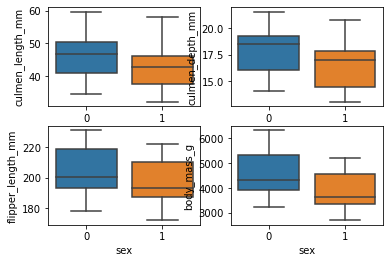

In [545]:
# basic exploratory analysis with boxplots
f, axes = plt.subplots(2, 2)
sns.boxplot(x=dataset['sex'],y=dataset['culmen_length_mm'], ax = axes[0][0])
sns.boxplot(x=dataset['sex'],y=dataset['culmen_depth_mm'], ax = axes[0][1])
sns.boxplot(x=dataset['sex'],y=dataset['flipper_length_mm'], ax = axes[1][0])
sns.boxplot(x=dataset['sex'],y=dataset['body_mass_g'], ax = axes[1][1])

In [546]:
# split the dataset into two parts (train & test)
train_dataset = dataset.sample(frac=0.7, random_state=42)
test_dataset = dataset.drop(train_dataset.index)

train_dataset.shape, test_dataset.shape

((233, 5), (100, 5))

In [547]:
# separate label column from the data
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop(label)
test_labels = test_features.pop(label)

train_features.shape, test_features.shape, train_labels.shape, test_labels.shape

((233, 4), (100, 4), (233,), (100,))

In [548]:
# normalizer for all feature columns
normalizer = preprocessing.Normalization()
normalizer.adapt(np.array(train_features))

normalized = np.array(normalizer(train_features))
normalized.mean(), normalized.std()

(6.344185e-08, 1.0)

In [549]:
# model definition
dnn_model = keras.Sequential([
      normalizer,
      layers.Dense(32, activation='relu'),
      #layers.Dense(16, activation='relu'),
      layers.Dense(1, activation='sigmoid')
])

dnn_model.compile(loss='binary_crossentropy', 
                  optimizer=tf.keras.optimizers.Adam(0.001),
                  metrics=['accuracy'])

In [550]:
dnn_model.summary()

Model: "sequential_47"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_34 (Normalizat (None, 4)                 9         
_________________________________________________________________
dense_127 (Dense)            (None, 32)                160       
_________________________________________________________________
dense_128 (Dense)            (None, 2)                 66        
Total params: 235
Trainable params: 226
Non-trainable params: 9
_________________________________________________________________


In [551]:
%%time
history = dnn_model.fit(
    train_features, train_labels,
    validation_split=0.2,
    verbose=0,
    epochs=200)

CPU times: user 5.09 s, sys: 424 ms, total: 5.52 s
Wall time: 4.25 s


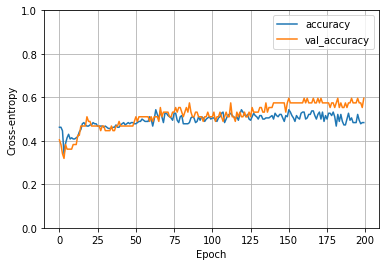

In [552]:
def plot_loss(history):
  plt.plot(history.history['accuracy'], label='accuracy')
  plt.plot(history.history['val_accuracy'], label='val_accuracy')
  plt.ylim([0, 1])
  plt.xlabel('Epoch')
  plt.ylabel('Cross-entropy')
  plt.legend()
  plt.grid(True)

plot_loss(history)

In [553]:
# evaluation on test data
test_evaluation = {}
test_evaluation['dnn_model'] = dnn_model.evaluate(
    test_features,
    test_labels, verbose=0)
test_evaluation

{'dnn_model': [0.6931855082511902, 0.47999998927116394]}